In [2]:
%load_ext autoreload
%autoreload 2
from get import *
from sklearn.manifold import TSNE
from matplotlib import cm

/home/t-boulet/projects/hackathon42/Hackaton42/timothe/venvHACK42/lib/python3.7/site-packages/torch/cuda/__init__.py:98: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


{0: '00_toy_dataset', 1: '01_mnist_cc', 2: '02_mnist_constant_image', 3: '03_mnist_constant_image_random_row', 4: '04_mnist_uniform_color_random_row', 5: '05_mnist_uniform_color_low_mix_rate', 6: '06_mnist_sum', 7: '07_mnist_sum_bis', 8: '08_mnist_sum_noise_level', 12: '12_mnist_mysterious', 13: '13_mnist_mysterious', 23: '23_mnist_embed', 456: '456_mnist_embed', 888: '888_vehicle_animal', 999: '999_humans'}


In [3]:
# Load data
X_labeled, y_labeled, X_unlabeled, X_val = load_datasets(n_dataset=456)
X_all = torch.concat((X_labeled, X_unlabeled, X_val))
labels_all = np.concatenate((y_labeled, np.zeros(X_unlabeled.shape[0]), np.ones(X_val.shape[0])))


In [4]:
print(X_labeled.shape)
print(X_unlabeled.shape)
print(X_val.shape)
print(X_all.shape)

print(y_labeled.unique())


torch.Size([1718, 198])
torch.Size([5153, 198])
torch.Size([1718, 198])
torch.Size([8589, 198])
tensor([4., 5., 6.])


In [5]:
# Project data and get projector
def get_2d_repr(embeddings):
    tsne = TSNE(2, verbose=1)
    tsne_proj = tsne.fit_transform(embeddings)
    return tsne, tsne_proj

tsne, repr_2d = get_2d_repr(X_all)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8589 samples in 0.001s...


/home/t-boulet/projects/hackathon42/Hackaton42/timothe/venvHACK42/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/t-boulet/projects/hackathon42/Hackaton42/timothe/venvHACK42/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 8589 samples in 2.384s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8589
[t-SNE] Computed conditional probabilities for sample 2000 / 8589
[t-SNE] Computed conditional probabilities for sample 3000 / 8589
[t-SNE] Computed conditional probabilities for sample 4000 / 8589
[t-SNE] Computed conditional probabilities for sample 5000 / 8589
[t-SNE] Computed conditional probabilities for sample 6000 / 8589
[t-SNE] Computed conditional probabilities for sample 7000 / 8589
[t-SNE] Computed conditional probabilities for sample 8000 / 8589
[t-SNE] Computed conditional probabilities for sample 8589 / 8589
[t-SNE] Mean sigma: 26.606743
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.696243
[t-SNE] KL divergence after 1000 iterations: 2.113010


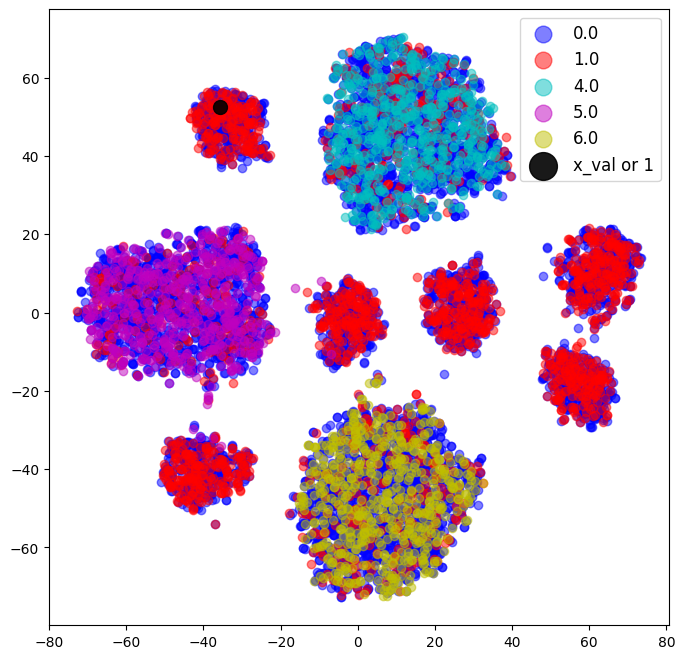

In [6]:
# Create a two dimensional t-SNE projection of the embeddings.
# Plot the points. We obserbe 4 clusters.
n_low = 104
k = 1
colors = ['b', 'r', 'g', 'y', 'c', 'm', 'y']
def plot_embedding_2d(embeddings, repr_2d, labels = None, title=None, plot_x_val_2d_repr = True):
    if labels is None:
        labels = np.zeros(embeddings.shape[0])
    # Plot those points as a scatter plot and label them based on the pred labels
    
    fig, ax = plt.subplots(figsize=(8,8))
    for lab in np.unique(labels):
        indices = labels==lab
        ax.scatter(repr_2d[indices,0], repr_2d[indices,1], c=colors[lab.astype(np.int32)], label = lab ,alpha=0.5)
    if plot_x_val_2d_repr:
        ax.scatter(repr_2d[labels == 1, 0][n_low: n_low + k], repr_2d[labels == 1, 1][n_low: n_low + k], c='k', label = 'x_val or 1', alpha=0.9, s = 100)
    ax.legend(fontsize='large', markerscale=2)
    plt.show()
    
plot_embedding_2d(X_all, repr_2d = repr_2d ,labels = labels_all)

In [7]:
from time import time

from pykeops.torch import LazyTensor
use_cuda = torch.cuda.is_available()
dtype = torch.float32 if use_cuda else torch.float64
device_id = "cuda:0" if use_cuda else "cpu"

embeddings_all = torch.concat((X_labeled, X_unlabeled, X_val))
K_clusters = 9
N, D, K = embeddings_all.shape[0], embeddings_all.shape[1], K_clusters

print(N, D, K)

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode
8589 198 9


In [12]:
# Cluster the points

def KMeans(x, K=10, Niter=10, verbose=True):
    """Implements Lloyd's algorithm for the Euclidean metric."""

    start = time()
    N, D = x.shape  # Number of samples, dimension of the ambient space

    random_indices = np.random.choice(N, K, replace=False)
    c = x[random_indices, :].clone()  # Simplistic initialization for the centroids

    x_i = LazyTensor(x.view(N, 1, D))  # (N, 1, D) samples
    c_j = LazyTensor(c.view(1, K, D))  # (1, K, D) centroids

    # K-means loop:
    # - x  is the (N, D) point cloud,
    # - cl is the (N,) vector of class labels
    # - c  is the (K, D) cloud of cluster centroids
    for i in range(Niter):

        # E step: assign points to the closest cluster -------------------------
        D_ij = ((x_i - c_j) ** 2).sum(-1)  # (N, K) symbolic squared distances
        cl = D_ij.argmin(dim=1).long().view(-1)  # Points -> Nearest cluster

        # M step: update the centroids to the normalized cluster average: ------
        # Compute the sum of points per cluster:
        c.zero_()
        c.scatter_add_(0, cl[:, None].repeat(1, D), x)

        # Divide by the number of points per cluster:
        Ncl = torch.bincount(cl, minlength=K).type_as(c).view(K, 1)
        c /= Ncl  # in-place division to compute the average

    if verbose:  # Fancy display -----------------------------------------------
        if use_cuda:
            torch.cuda.synchronize()
        end = time()
        print(
            f"K-means for the Euclidean metric with {N:,} points in dimension {D:,}, K = {K:,}:"
        )
        print(
            "Timing for {} iterations: {:.5f}s = {} x {:.5f}s\n".format(
                Niter, end - start, Niter, (end - start) / Niter
            )
        )

    return cl, c


cluster_classes_all, c = KMeans(embeddings_all, K, Niter=20)
print("Centroids: ", c.shape)
print("Labels: ", cluster_classes_all.shape)
print(cluster_classes_all[10:])

K-means for the Euclidean metric with 8,589 points in dimension 198, K = 9:
Timing for 20 iterations: 0.12380s = 20 x 0.00619s

Centroids:  torch.Size([9, 198])
Labels:  torch.Size([8589])
tensor([3, 5, 1,  ..., 5, 2, 5])


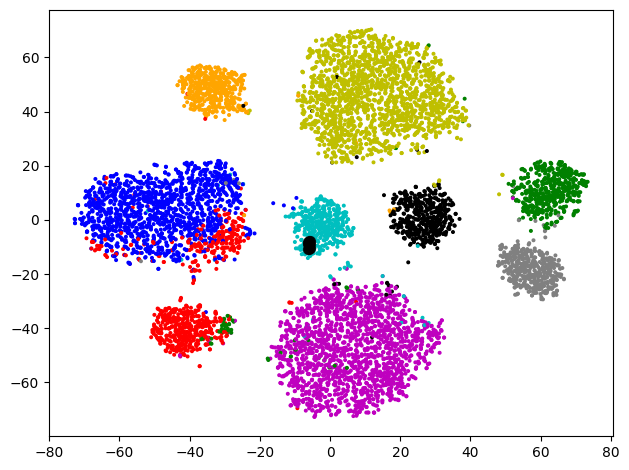

In [13]:
plt.figure()
colors = ['b', 'r', 'g', 'y', 'c', 'm', 'orange', 'k', 'grey']
colors2 = [colors[i] for i in cluster_classes_all]
plt.scatter(repr_2d[:, 0], repr_2d[:, 1], c=colors2, s=30000 / len(repr_2d))
plt.scatter(c[:, 0], c[:, 1], c="black", s=50, alpha=0.8)
plt.tight_layout()
plt.show()

In [10]:

# BLUE = cluster 0 = label 4
# GREEN = cluster 2 = label 6
# CYAN = cluster 4 = label 5

# RED = cluster 1 = label 4
# YELLOW = cluster 3 = label 6
# MAGENTA = cluster 5 = label probably 5
# ORANGE = cluster 6 = label 4
# BLACK = cluster 7 = label 6
# GREY = cluster 8 = label 5

cluster_classes_all # [cluster class of i for i in range(N)]



classes_all = cluster_classes_all.clone()     # [class 2 or 3 of i for i in range(N)]

classes_all[cluster_classes_all == 0] = 4
classes_all[cluster_classes_all == 2] = 6
classes_all[cluster_classes_all == 4] = 5

classes_all[cluster_classes_all == 1] = 4
classes_all[cluster_classes_all == 3] = 6
classes_all[cluster_classes_all == 5] = 5
classes_all[cluster_classes_all == 6] = 4
classes_all[cluster_classes_all == 7] = 6
classes_all[cluster_classes_all == 8] = 5

classes_val = classes_all[labels_all == 1]

print(classes_val.shape)

torch.Size([1718])


In [11]:
df = pd.DataFrame(classes_val)
df.to_csv(f"submission_456.csv", header=False, index=False)